<a href="https://colab.research.google.com/github/urvashiramdasani/NLP/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import itertools

animals = ['cat','dog','goat','elephant','eagle','zebra','rhino', 'hippo']
actions = ['sat','stood','jumped','slept']
furniture = ['mat','rug','sofa','bed']

# Generate all combinations of animal, action and furniture
animal_corpus = ['The {} {} on the {}'.format(x[0], x[1], x[2]) for x in itertools.product(animals, actions, furniture)]
vocabulary_size = len(animals) + len(actions) + len(furniture) + 2

print("There are {} sentences in the corpus, with a vocabulary of {} words".format(len(animal_corpus), vocabulary_size))

There are 128 sentences in the corpus, with a vocabulary of 18 words


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
import numpy as np

# Hyper-parameters

EMBEDDING_SIZE = 7  # Small corpus, so we're using a small dimension
WINDOW_SIZE = 2     # Empirically found to work well. Initial value 4

# Convert text to numerical sequences

# Note that the Tokenizer starts numbering words with 1.  So we have vocabulary_size+1 words.  The 0-th word
# is considered to be the 'Out-of-vocabulary' token.
tokenizer = Tokenizer(num_words=vocabulary_size+1, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ', lower=True, split=' ',)
tokenizer.fit_on_texts(animal_corpus)
sequences = tokenizer.texts_to_sequences(animal_corpus)

# Generate (target, context) pairs with negative sampling

pairs = []
labels = []

for this_sequence in sequences:
    # Again note the vocabulary_size+1 expression
    c, l = skipgrams(this_sequence, vocabulary_size+1, window_size=WINDOW_SIZE, negative_samples=1, shuffle=True)
    for i in range(len(c)):
        pairs.append(c[i])
        labels.append(l[i])
pairs = np.array(pairs)
labels = np.array(labels)
    
print("There are {} (context,target) pairs in the dataset".format(len(pairs)))

There are 4608 (context,target) pairs in the dataset


In [3]:
from keras.layers import Embedding, Input, Dense, Reshape
from keras.layers.merge import Dot, Concatenate, Add, Maximum, Minimum, Average, Multiply, Subtract
from keras.models import Model
from keras.optimizers import RMSprop, Adadelta, Adagrad, Adam, Adamax, Nadam, Ftrl, SGD



target_word = Input((1,))
context_word = Input((1,))

# An embedding layer is just a lookup table - a matrix of size vocabulary_size x EMBEDDING_SIZE
# We select input_length rows from this matrix

embedding_layer = Embedding(vocabulary_size + 1, EMBEDDING_SIZE, input_length = 1, name = 'embedding_layer') ##TODO## :  Add embedding layer nambed 'embedding_layer'.  Remember to add 1 to the vocabulary size!

# Expect an output of similarity score between 0 and 1
output_layer = Dense(1, activation='sigmoid')

# Select the row indexed by target_word, reshape it for convenience
target_embedding = embedding_layer(target_word)
target_embedding = Reshape((EMBEDDING_SIZE,))(target_embedding)

# Select the row indexed by context_word, reshape it for convenience
context_embedding = embedding_layer(context_word)
context_embedding = Reshape((EMBEDDING_SIZE,))(context_embedding)


# Perform the dot product on the two embeddings, and run through the output sigmoid 
output = Dot(axes = 1)([target_embedding, context_embedding]) ##TODO## : Add dot product layer

output = output_layer(output)
    
# Setup a model for training
model = Model(inputs=[target_word, context_word], outputs=output)

optimizer = RMSprop(lr=0.001, rho=0.99)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 7)         133         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 7)            0           embedding_layer[0][0]        

In [4]:
# Only print the results after this many epochs
INTERNAL_EPOCHS = 100

TOTAL_EPOCHS = 1500

def train(X,y):
    for index in range(int(TOTAL_EPOCHS / INTERNAL_EPOCHS)):
        h = model.fit(x=X, y=y, batch_size=256, epochs=INTERNAL_EPOCHS, verbose=0)
        print('Epoch {} - loss {}'.format((index + 1) * INTERNAL_EPOCHS, h.history['loss'][-1]))

train([pairs[:,0], pairs[:,1]], labels)        


Epoch 100 - loss 0.533477246761322
Epoch 200 - loss 0.5298049449920654
Epoch 300 - loss 0.5288598537445068
Epoch 400 - loss 0.5283042788505554
Epoch 500 - loss 0.5279319286346436
Epoch 600 - loss 0.5276448726654053
Epoch 700 - loss 0.5273759365081787
Epoch 800 - loss 0.5273505449295044
Epoch 900 - loss 0.5272536873817444
Epoch 1000 - loss 0.527176558971405
Epoch 1100 - loss 0.5271828174591064
Epoch 1200 - loss 0.5272847414016724
Epoch 1300 - loss 0.5271743535995483
Epoch 1400 - loss 0.527154266834259
Epoch 1500 - loss 0.5271297693252563


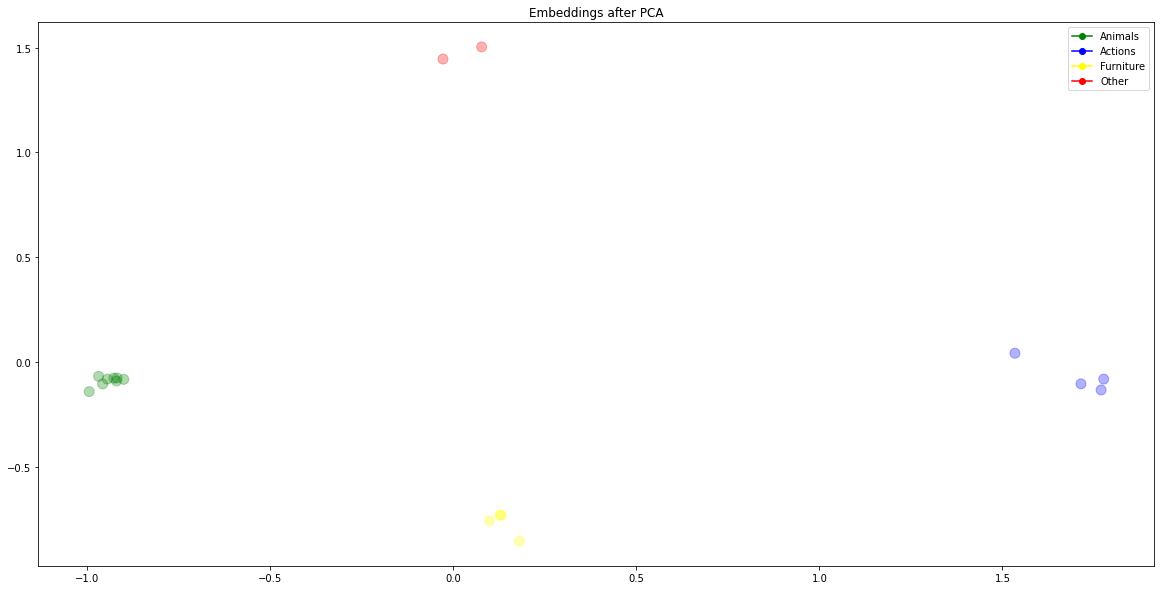

In [5]:
%matplotlib inline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


category_colors = {'animals' : 'green', 
                   'actions' : 'blue',
                   'furniture' : 'yellow'}

colors = []
for i in range(vocabulary_size):
    colors.append('red')
    
for word in tokenizer.word_index:
    index = tokenizer.word_index[word] -1
    if word in animals:
        colors[index] = category_colors['animals']
    elif word in actions:
        colors[index] = category_colors['actions']
    elif word in furniture:
        colors[index] = category_colors['furniture']
        
def plot_embeddings_after_pca(vectors):  
        """
        Perform PCA and plot the resulting 2 components on X and Y axis
        Args:
          embedding_weights - the set of vectors to 
        """
        pca = PCA(n_components=2)
        vectors_pca = pca.fit_transform(vectors)
        plt.figure(figsize=(20,10))
        
        # We do not draw the first element, which is the 'Out-of-Vocabulary' token
        plt.scatter(vectors_pca[1:,0], vectors_pca[1:,1], c=colors, s=100, alpha=0.3);
        plt.title('Embeddings after PCA')
        legend_elements = [
                    plt.Line2D([0], [0], marker='o', color=category_colors['animals'], label='Animals'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['actions'], label='Actions'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['furniture'], label='Furniture'),
                    plt.Line2D([0], [0], marker='o', color='red', label='Other'),
                  ]

        # Create the figure
        plt.legend(handles=legend_elements);

        
plot_embeddings_after_pca(model.get_layer('embedding_layer').get_weights()[0])